# Import Data & Python Packages

In [47]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [48]:
# get titanic & test csv files as a DataFrame

#developmental data (train)
titanic_df = pd.read_csv(r"C:\Users\LENOVO\Downloads\train.csv")

#cross validation data (hold-out testing)
test_df    = pd.read_csv(r"C:\Users\LENOVO\Downloads\test.csv")

# preview developmental data
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


da=pd.read_csv(r'C:\Users\LENOVO\Downloads\gender_submission (1).csv')
da

In [49]:
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Assess Data Quality & Missing Values 

In [50]:
# check missing values in train dataset
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 2.1 Age - Missing Values 

In [51]:
sum(pd.isnull(titanic_df['Age']))

177

In [52]:
# proportion of "Age" missing
round(177/(len(titanic_df["PassengerId"])),4)

0.1987

~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.

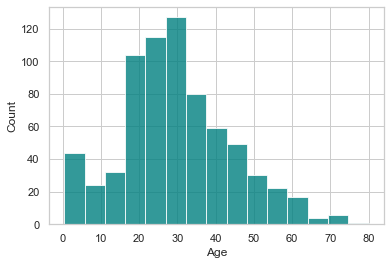

In [53]:
ax = titanic_df["Age"].hist(bins=15, color='teal', alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

In [54]:
# median age is 28 (as compared to mean which is ~30)
titanic_df["Age"].median(skipna=True)

28.0

# 2.2 Cabin - Missing Values 

In [55]:
# proportion of "cabin" missing
round(687/len(titanic_df["PassengerId"]),4)

0.771

77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise. We'll ignore this variable in our model.

# 2.3 Embarked - Missing Values 

In [56]:
# proportion of "Embarked" missing
round(2/len(titanic_df["PassengerId"]),4)

0.0022

There are only 2 missing values for "Embarked", so we can just impute with the port where most people boarded.

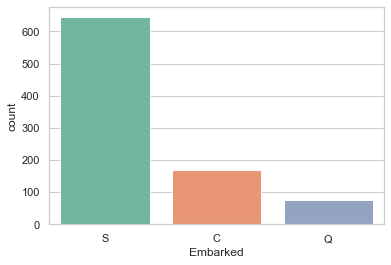

In [57]:
sns.countplot(x='Embarked',data=titanic_df,palette='Set2')
plt.show()

By far the most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S".

# 2.4 Final Adjustments to Data 

Based on my assessment of the missing values in the dataset, I'll make the following changes to the data:

* If "Age" is missing for a given row, I'll impute with 28 (median age).
* If "Embark" is missing for a riven row, I'll impute with "S" (the most common boarding port).
* I'll ignore "Cabin" as a variable. There are too many missing values for imputation. Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [58]:
train_data = titanic_df
train_data["Age"].fillna(28, inplace=True)
train_data["Embarked"].fillna("S", inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

# 2.4.1 Additional Variables Exploratory Data Analysis Logistic Regression 

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family. For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [59]:
## Create categorical variable for traveling alone

train_data['TravelBuds']=train_data["SibSp"]+train_data["Parch"]
train_data['TravelAlone']=np.where(train_data['TravelBuds']>0, 0, 1)

In [60]:
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)
train_data.drop('TravelBuds', axis=1, inplace=True)

I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked").

In [61]:
#create categorical variable for Pclass

train2 = pd.get_dummies(train_data, columns=["Pclass"])

In [62]:
train3 = pd.get_dummies(train2, columns=["Embarked"])

In [63]:
train4=pd.get_dummies(train3, columns=["Sex"])
train4.drop('Sex_female', axis=1, inplace=True)

In [64]:
train4.drop('PassengerId', axis=1, inplace=True)
train4.drop('Name', axis=1, inplace=True)
train4.drop('Ticket', axis=1, inplace=True)
train4.head(5)

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


In [65]:
df_final = train4

Now, apply the same changes to the test data.
I will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28).
I'll also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis.
There were no missing values in the "Embarked" port variable.
I'll add the dummy variables to finalize the test set.
Finally, I'll impute the 1 missing value for "Fare" with the median, 14.45.

In [66]:
test_df["Age"].fillna(28, inplace=True)
test_df["Fare"].fillna(14.45, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [67]:
test_df['TravelBuds']=test_df["SibSp"]+test_df["Parch"]
test_df['TravelAlone']=np.where(test_df['TravelBuds']>0, 0, 1)

test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)
test_df.drop('TravelBuds', axis=1, inplace=True)

test2 = pd.get_dummies(test_df, columns=["Pclass"])
test3 = pd.get_dummies(test2, columns=["Embarked"])

test4=pd.get_dummies(test3, columns=["Sex"])
test4.drop('Sex_female', axis=1, inplace=True)

test4.drop('PassengerId', axis=1, inplace=True)
test4.drop('Name', axis=1, inplace=True)
test4.drop('Ticket', axis=1, inplace=True)
final_test = test4

In [68]:
final_test.head(5)

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


# 4. 1 Hold-Out Testing & Logistic Model Assessment 

### 4.2 Kaggle "Test" Dataset 

# 4.3 Using 80-20 Split for Cross Validation

In [69]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_final, test_size=0.2)

# 4.3 Re-run Logistic Regression w/ 80-20 Split 

In [70]:
#re-fit logistic regression on new train sample

cols2=["Age", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male"] 
X3=train[cols2]
Y3=train['Survived']


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X3, Y3)
logreg.score(X3, Y3)

0.7921348314606742

The score for the new training sample (80% of original) is very close to the original performance, which is good!
Let's assess how well it scores on the 20% hold-out sample.

In [72]:
from sklearn import metrics
logreg.fit(X3, Y3)

X3_test = test[cols2]
Y3_test = test['Survived']

Y3test_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, Y3_test)))

Accuracy of logistic regression classifier on test set: 0.80


The model's out of sample performance does not show any deterioration

# 4.4 Out-of-sample test results 

### Assessing the model's performance based on Cross Validation ROC/AUC

In [73]:
# Model's in sample AUC

from sklearn.metrics import roc_auc_score
logreg.fit(X3, Y3)
Y3_pred = logreg.predict(X3)

y_true = Y3
y_scores = Y3_pred
roc_auc_score(y_true, y_scores)

0.7731673235099698

ROC AUC: 0.856


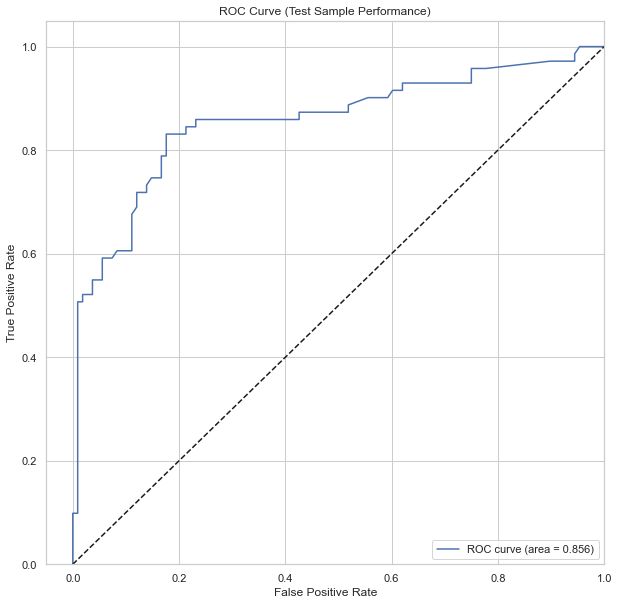

In [74]:
#Visualizing the model's ROC curve (**source for graph code given below the plot)
from sklearn.metrics import roc_curve, auc
logreg.fit(X3, Y3)

y_test = Y3_test
X_test = X3_test
 
# Determine the false positive and true positive rates
FPR, TPR, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
 
# Calculate the AUC

roc_auc = auc(FPR, TPR)
print ('ROC AUC: %0.3f' % roc_auc )
 
# Plot of a ROC curve
plt.figure(figsize=(10,10))
plt.plot(FPR, TPR, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc="lower right")
plt.show()

An AUC score of 0.5 is effectively as good as the flip of a coin, and means that the model really has no classification power at all between the positive and negative occurences. The AUC for both the test and train samples when run on my logistic regression demonstrates relatively strong power of separation between positive and negative occurences (survived - 1, died - 0).

# 4.5 Logistic Regression Conclusions 

Based on my analysis, if you were to be aboard the Titanic, your chances of survival were best if you fit the following criteria:

* Female
* Young
* In First Class
* Embarked in Cherbourg France